In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
from desiutil.log import get_logger#, DesiLogContext, WARNING
from astropy.table import Table, Column, hstack, vstack, join
from desitarget.io import read_targets_in_tiles
import glob
import sklearn.metrics
log = get_logger()

In [2]:
desi_root = desi_root = os.getenv('DESI_ROOT')
projectdir = os.path.join(desi_root, 'users', 'ioannis', 'fastspecfit', 'redrock-templates')

In [3]:
projectdir

'/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates'

In [4]:
# https://github.com/moustakas/fastspecfit-projects/blob/main/redrock-templates/stack-templates#L158
def read_vi(vi_spectype=None, quality=2.5):
    # see https://data.desi.lbl.gov/doc/releases/edr/vac/vi/
    from glob import glob
    #vifiles = glob('/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/*.csv')
    allvi = []
    for targ in ['BGS', 'LRG', 'ELG', 'QSO']:
        vifile = f'/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_{targ}_v1.csv'
        vi = Table.read(vifile)
        vi['SUFFIX'] = targ # os.path.basename(vifile).replace('EDR_VI_', '').replace('_v1.csv', '')
        allvi.append(vi)
    allvi = vstack(allvi)
    I = np.where(allvi['VI_QUALITY'] >= quality)[0]
    log.info(f'Trimming to {len(I):,d}/{len(allvi):,d} VI redshifts.')
    allvi = allvi[I]

    _, uindx = np.unique(allvi['TARGETID'], return_index=True)
    log.info(f'Trimming to {len(uindx):,d}/{len(allvi):,d} unique targets.')
    allvi = allvi[uindx]

    if vi_spectype:
        I = allvi['VI_SPECTYPE'] == vi_spectype
        log.info(f'Trimming to {np.sum(I):,d}/{len(allvi):,d} objects with VI_SPECTYPE={vi_spectype}.')
        allvi = allvi[I]
    
    return allvi

In [5]:
all_vi = read_vi()
assert np.unique(all_vi["TARGETID"]).size == len(all_vi)

tiles_edr = Table.read('/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/tiles-fuji.fits')

tiles_sv = tiles_edr[((tiles_edr['SURVEY']=='sv3')|(tiles_edr['SURVEY']=='sv1'))&(tiles_edr['PROGRAM']!='backup')]
tiles_sv['RA'], tiles_sv['DEC'] = tiles_sv['TILERA'], tiles_sv['TILEDEC']

tileid_vi = list(set(all_vi["TILEID"]))
tilera_vi = []
tiledec_vi = []
for tileid in tileid_vi:
    ii = tiles_edr['TILEID']==tileid
    tilera_vi.append(float(tiles_edr['TILERA'][ii]))
    tiledec_vi.append(float(tiles_edr['TILEDEC'][ii]))
    print(np.count_nonzero(ii))
tiles_vi = Table()
tiles_vi["TILEID"], tiles_vi["RA"], tiles_vi["DEC"] = tileid_vi, tilera_vi, tiledec_vi

INFO:2913814911.py:14:read_vi: Trimming to 17,275/20,373 VI redshifts.
INFO:2913814911.py:18:read_vi: Trimming to 17,083/17,275 unique targets.
1
1
1
1
1
1
1
1


In [6]:
tiles_vi

TILEID,RA,DEC
int64,float64,float64
80608,106.74,56.2
80609,150.12,2.206
80610,150.12,2.306
80613,106.74,56.1
80670,38.0,-2.8
80605,36.448,-4.601
80606,36.448,-4.501
80607,106.74,56.1


In [7]:
tiles_sv

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221,144.0,65.0
80622,sv1,dark,lrgqso,sv1lrgqso,6,5400.3,155.0,32.325,0.0,4916.9,0.0,4000.0,obsstart,4772.1,4916.9,4739.8,6935.4,dark,0.9,20201221,155.0,32.325
80623,sv1,dark,elg,sv1elg,8,7200.4,155.0,32.425,0.0,4969.7,0.0,4000.0,obsstart,4903.1,4969.7,4916.9,7266.2,dark,0.9,20201221,155.0,32.425
80611,sv1,bright,bgsmws,sv1bgsmws,12,3600.9,35.22,30.3,0.0,669.2,0.0,600.0,obsstart,641.1,723.7,669.2,407.7,bright,0.9,20201222,35.22,30.3
80617,sv1,bright,bgsmws,sv1bgsmws,16,4801.0,5.0,28.0,0.0,1309.5,0.0,600.0,obsstart,1251.7,1369.7,1309.5,884.1,bright,0.9,20201223,5.0,28.0
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2


In [8]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark"
main_dark = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_dark["TARGETID"]).size == len(main_dark)


In [9]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright"
main_bright = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_bright["TARGETID"]).size == len(main_bright)

In [10]:
in_dark = np.in1d(all_vi['TARGETID'], main_dark['TARGETID'])
in_bright = np.in1d(all_vi['TARGETID'], main_bright['TARGETID'])
print(np.count_nonzero(in_dark|in_bright))

8039


In [11]:
all_vi_in_main = all_vi[in_dark|in_bright]
all_vi_in_main.sort('TARGETID')
all_vi.sort('TARGETID')

In [12]:
path_reference = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-iron/vitiles/'

exp_names = ['NMF-0.1', 'NMF-0.2', 'NMF-0.3', 'NMF-0.4b', 'NMF-0.5', 'NMF-0.5b', 'PCA-0.1', 'PCA-0.2']

paths  = []

for temp in exp_names:
    tmp_path = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-{}-zscan01/vitiles/'.format(temp)
    print(tmp_path)
    paths.append(tmp_path)

/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.2-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.3-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.2-zscan01/vitiles/


In [13]:
def gather_redrock_outputs(redrock_path):
    zcatfiles = glob.glob(os.path.join(redrock_path,'zcat*.fits'))
    zcat = vstack([Table(fitsio.read(zcatfile)) for zcatfile in zcatfiles])
    zcat = zcat[zcat['ZWARN']==0]
    return zcat

In [14]:
z = gather_redrock_outputs(paths[0])

In [15]:
np.count_nonzero(z['ZWARN']==0), len(z)

(16963, 16963)

In [16]:
def precision_recall(redrock_path, vi_data):
    tmp_vi_data = vi_data.copy()
    labels = ['GALAXY', 'QSO', 'STAR']
    zcat = gather_redrock_outputs(redrock_path)
    in_truth = np.isin(zcat['TARGETID'], tmp_vi_data['TARGETID'])
    zcat = zcat[in_truth]
    zcat.sort('TARGETID')
    in_zcat = np.isin(tmp_vi_data['TARGETID'], zcat['TARGETID'])
    tmp_vi_data = tmp_vi_data[in_zcat]
    tmp_vi_data.sort('TARGETID')
    assert np.unique(zcat['TARGETID']).size == len(zcat)
    assert np.array_equal(tmp_vi_data['TARGETID'], zcat['TARGETID'])
    recall = sklearn.metrics.recall_score(tmp_vi_data['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)
    precision = sklearn.metrics.precision_score(tmp_vi_data['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)
    f1 = sklearn.metrics.f1_score(tmp_vi_data['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)

    return precision, recall, f1

In [17]:
def find_differences(path_reference, other_paths, truth_data, exp_names):
    reference_values = precision_recall(path_reference, truth_data)
    other_values = {}
    for i, path in enumerate(other_paths):
        print(path)
        other_values[exp_names[i]] = precision_recall(path, truth_data)
    
    delta_precision = np.random.rand(3, len(exp_names))
    delta_recall = np.random.rand(3, len(exp_names))

    for i, name in enumerate(exp_names):
        delta_precision[:,i] = other_values[name][0]-reference_values[0]
        delta_recall[:,i] = other_values[name][1]-reference_values[1]
    return {'precision':delta_precision, 'recall':delta_recall}

In [18]:
all_vi_deltas =  find_differences(path_reference, paths, all_vi, exp_names)

/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.2-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.3-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.2-zscan01/vitiles/


In [19]:
in_main_vi_deltas =  find_differences(path_reference, paths, all_vi_in_main, exp_names)

/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.2-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.3-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.2-zscan01/vitiles/


In [20]:
def plot_differences(delta_values, title='Title', outputfig=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(delta_values*100, vmin=-20, vmax=+20, cmap='coolwarm')

    # Add colorbar to show the mapping of values to colors
    cbar = plt.colorbar(heatmap)

    # Step 4: Display the plot
    plt.title(title)
    plt.xlabel('Experiment')
    plt.ylabel('Type')

    # Customize tick labels
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(exp_names, rotation=90)  # Set the experiment names as tick labels
    ax.set_yticklabels(['GALAXY', 'QSO', 'STAR'])

    # Add text annotations with numerical values
    for i in range(3):
        for j in range(8):
            text = ax.text(j, i, f'{100*delta_values[i, j]:.2f}', ha='center', va='center', color='black')
            
    if outputfig:
        plt.savefig(outputfig, bbox_inches='tight')


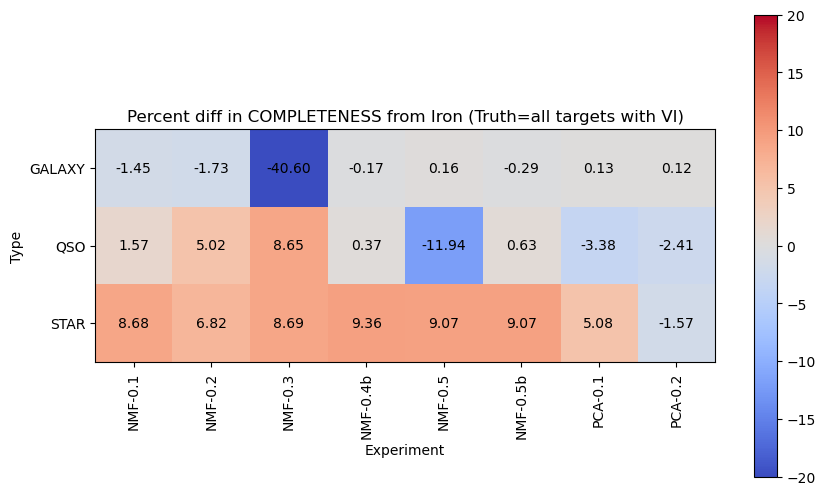

In [21]:
plot_differences(all_vi_deltas['recall'], title='Percent diff in COMPLETENESS from Iron (Truth=all targets with VI)', 
                outputfig='completeness_all_targets.jpg')

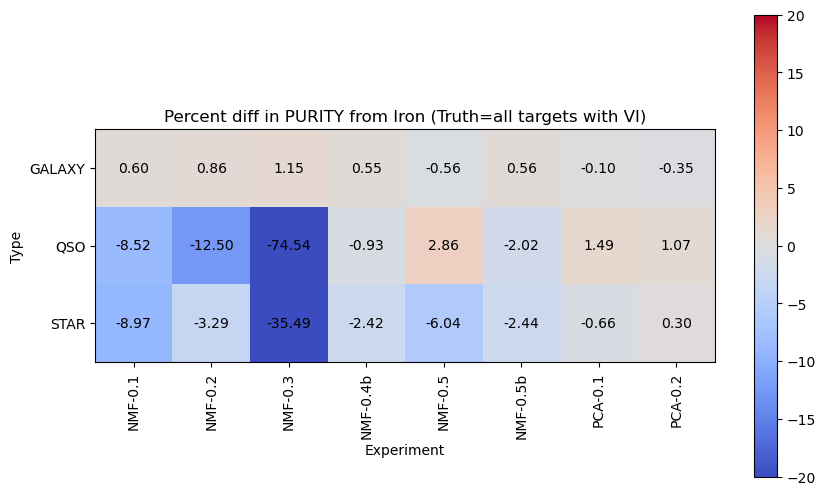

In [22]:
plot_differences(all_vi_deltas['precision'], title='Percent diff in PURITY from Iron (Truth=all targets with VI)', 
                outputfig='purity_all_targets.jpg')

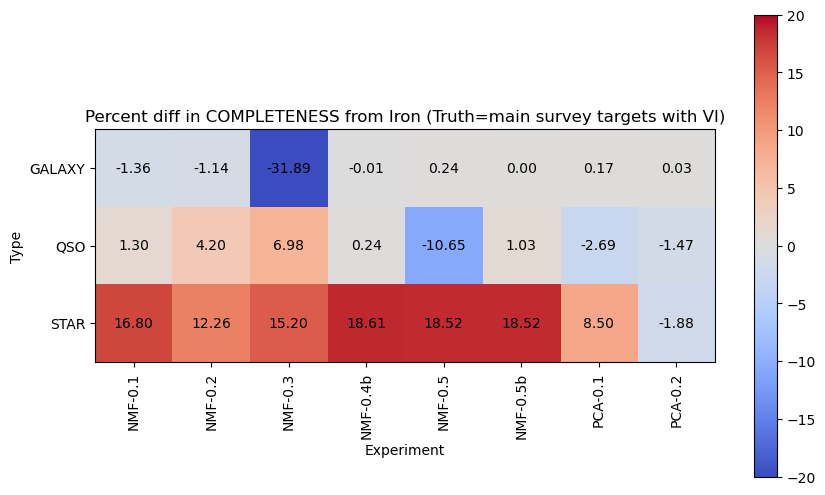

In [23]:
plot_differences(in_main_vi_deltas['recall'], title='Percent diff in COMPLETENESS from Iron (Truth=main survey targets with VI)', 
                outputfig='completeness_main_targets.jpg')

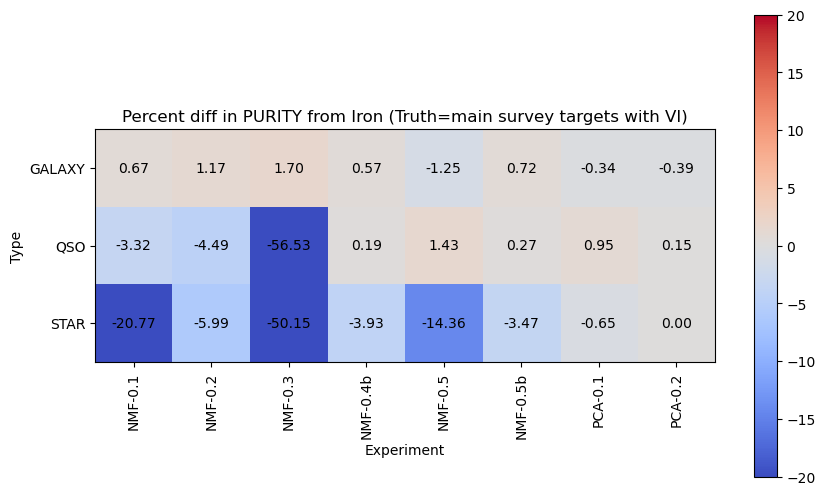

In [24]:
plot_differences(in_main_vi_deltas['precision'], title='Percent diff in PURITY from Iron (Truth=main survey targets with VI)', 
                outputfig='purity_main_targets.jpg')